# การทดลองที่2 : การทดลองปรับค่าพารามิเตอร์เพื่อสร้างโมเดลการทำนายค่าแบบต่างๆ และเปรียบเทียบประสิทธิภาพของโมเดลทดสอบ

# ตอนที่1: การทดลองเตรียมข้อมูล ปรับค่าข้อมูล และจัดแบ่งชุด Train, Test เพื่อสอนโมเดล

## 1.1 เตรียมข้อมูลทดลอง

In [2]:
# Stock data
import quandl
import datetime

# Analyzing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics

In [3]:
stock_MSFT = pd.read_csv('MSFT.csv')

# stock_MSFT = quandl.get("WIKI/MSFT")
# stock_MSFT.to_csv('MSFT.csv')
# stock_MSFT.index = pd.to_datetime(stock_MSFT.index)
stock_MSFT

,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
0,1986-03-13,25.500,29.250,25.50,28.00,3582600.0,0.0,1.0,0.058941,0.067609,0.058941,0.064720,1.031789e+09
1,1986-03-14,28.000,29.500,28.00,29.00,1070000.0,0.0,1.0,0.064720,0.068187,0.064720,0.067031,3.081600e+08
2,1986-03-17,29.000,29.750,29.00,29.50,462400.0,0.0,1.0,0.067031,0.068765,0.067031,0.068187,1.331712e+08
3,1986-03-18,29.500,29.750,28.50,28.75,235300.0,0.0,1.0,0.068187,0.068765,0.065876,0.066454,6.776640e+07
4,1986-03-19,28.750,29.000,28.00,28.25,166300.0,0.0,1.0,0.066454,0.067031,0.064720,0.065298,4.789440e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8071,2018-03-21,92.930,94.050,92.21,92.48,23753263.0,0.0,1.0,92.930000,94.050000,92.210000,92.480000,2.375326e+07
8072,2018-03-22,91.265,91.750,89.66,89.79,37578166.0,0.0,1.0,91.265000,91.750000,89.660000,89.790000,3.757817e+07
8073,2018-03-23,89.500,90.460,87.08,87.18,42159397.0,0.0,1.0,89.500000,90.460000,87.080000,87.180000,4.215940e+07
8074,2018-03-26,90.610,94.000,90.40,93.78,55031149.0,0.0,1.0,90.610000,94.000000,90.400000,93.780000,5.503115e+07


## 1.2 ปรับรูปแบบของข้อมูล 

In [4]:
# สร้างข้อมูลทางเลือกด้วยการทำ Normalization ข้อมูล ‘Close’ ที่เลือก
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
stock_MSFT['Close_norm'] = scaler.fit_transform(np.array(stock_MSFT['Close']).reshape(-1, 1))

# สร้างข้อมูลราคาวันถัดไป Next_N-day เพื่อใช้เป็นคำตอบ (Ground Truth) ในการคาดการณ์
Next_N_day = 30
stock_MSFT = stock_MSFT.iloc[:len(stock_MSFT) - Next_N_day, :]

## 1.3 จัดเตรียมข้อมูลสำหรับ train validation และ test


In [5]:
# ข้อมูล test ให้ใช้ข้อมูล ‘GT’ ช่วง 60 วันท้าย
test_df = stock_MSFT.iloc[len(stock_MSFT) - 60:, :]
X_test = test_df.index
y_test = test_df.Close_norm

# เตรียมข้อมูล train, validate
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
    stock_MSFT.iloc[:len(stock_MSFT) - 60, :].index,
    stock_MSFT.iloc[:len(stock_MSFT) - 60, :].Close_norm,
    test_size=0.33, random_state=42)

## 1.4 แสดงรูปกราฟการกระจายของ train validate ที่แบ่งจากข้อ 1.3

Text(0.5, 1.0, 'Train dataset')

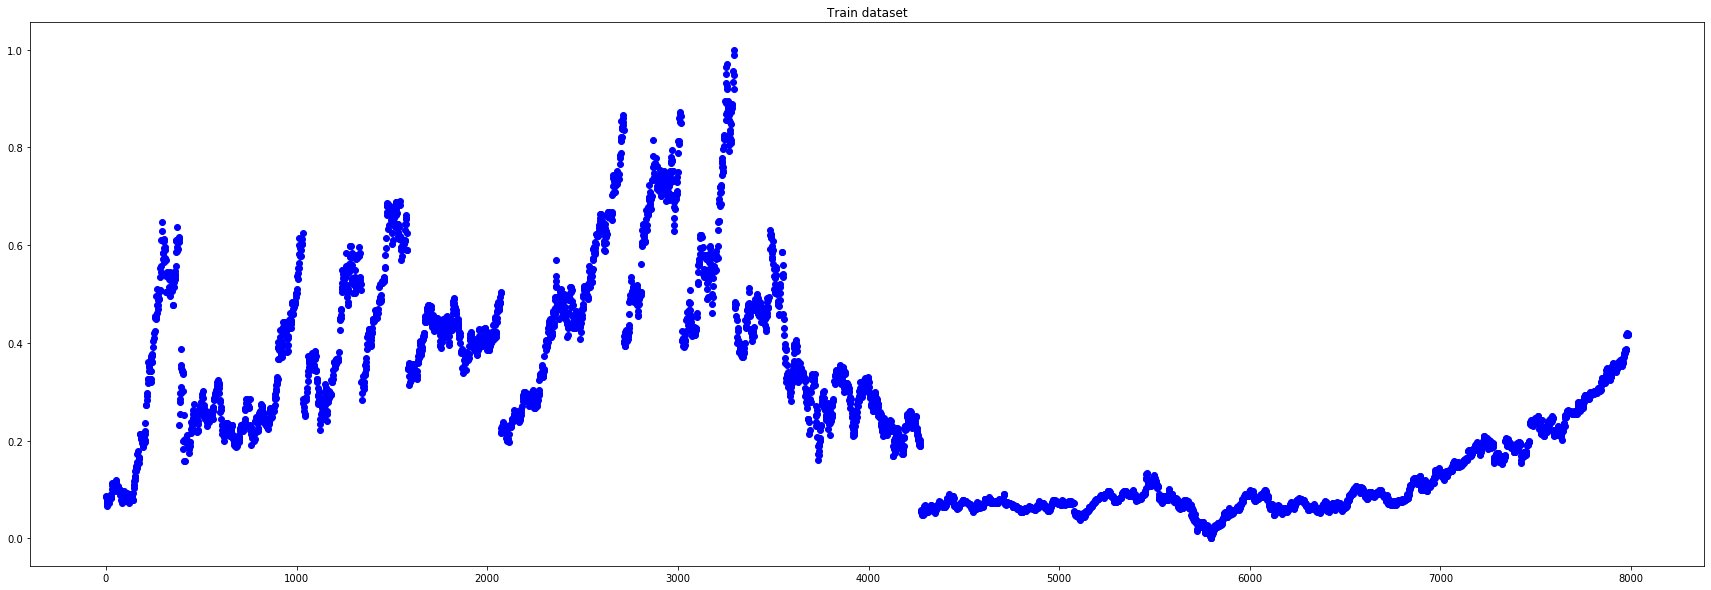

In [6]:
# ตั้งค่าขนาดพื้นที่ภาพ
plt.figure(figsize=(30,10))

# scatter plot ความสัมพันธ์ของค่า X_train, y_train 
plt.scatter(X_train, y_train, marker='o', color='blue')
plt.title('Train dataset')

Text(0.5, 1.0, 'Test dataset')

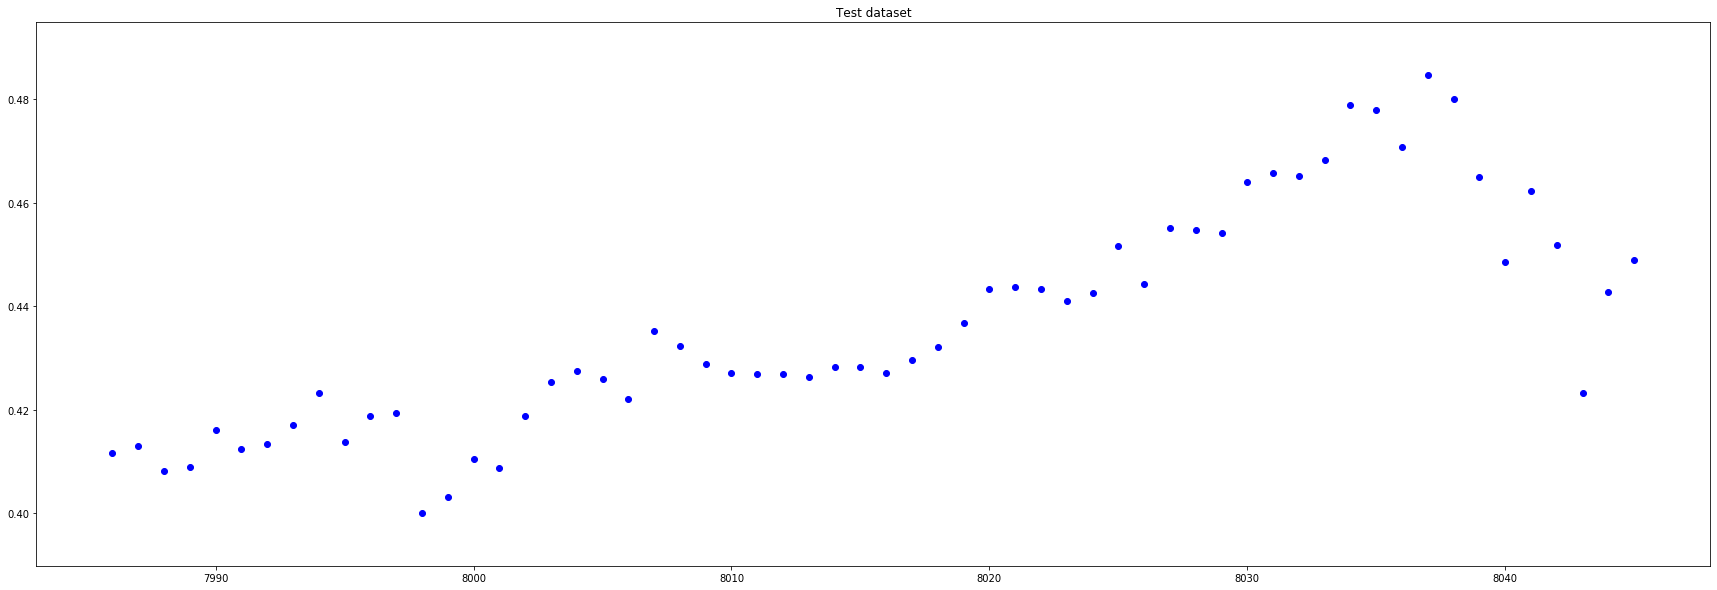

In [7]:
# ตั้งค่าขนาดพื้นที่ภาพ
plt.figure(figsize=(30,10))

# scatter plot ความสัมพันธ์ของค่า X_test, y_test
plt.scatter(X_test, y_test, marker='o', color='blue')
plt.title('Test dataset')

# ตอนที่ 2: การทดลองทำ Cross validation และ prediction เพื่อดูค่าความแม่นยำของแต่ละโมเดล

## 2.1 ทำการทดสอบพารามิเตอร์สำหรับโมเดลด้วยการทำ Cross Validation


In [11]:
from sklearn.model_selection import KFold, cross_val_score

# สร้างโมเดลรูปแบบ cross validation ที่ต้องการใช้ ในที่นี้ใช้ K-Fold โดยใช้ฟังก์ชัน
kf = KFold(n_splits=5, random_state=2011, shuffle=True)

# สร้าง prediction model พร้อมระบุพารามิเตอร์ที่ต้องการ
# Linear Regression Model
LRM = LinearRegression()

# Support Vector Regression (SVR) Model จำนวน 3 รูปแบบ kernel
c_val = 1000                    # ค่าปรับเข้มงวดกับ outlier bound [10^-6, 10^6] ค่าที่น่าสนใจ 1000
gramma_value = 0.1              # ค่าการควบคุมรูปร่างของโมเดล [10^-6, 10^6] ค่าน่าสนใจ 0.1
svr_lin = SVR(kernel='linear', C=c_val)
svr_rbf = SVR(kernel='rbf', C=c_val, gamma=gramma_value)
svr_poly = SVR(kernel='poly', C=c_val, degree=2)

# ทำ cross validation สำหรับแต่ละโมเดล model_name
# dt = np.array(X_train).reshape(-1, 1).astype('datetime64[D]').astype(int)
LRM_cross = cross_val_score(LRM, np.array(X_train).reshape(-1, 1), y_train, cv=kf)
# svr_lin_cross = cross_val_score(svr_lin, dt, y_train, cv=kf)
# svr_rbf_cross = cross_val_score(svr_rbf, dt, y_train, cv=kf)
# svr_poly_cross = cross_val_score(svr_poly, dt, y_train, cv=kf)

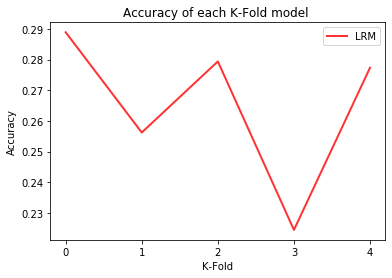

In [12]:
# แสดงรูปกราฟเปรียบเทียบ score ที่ได้จากโมเดลทั้ง 4 แบบที่คำนวณข้างบน

from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(np.arange(len(LRM_cross)), LRM_cross, color='red', alpha=0.8, lw=2)
# ax.plot(np.arange(len(LRM_cross)), [0.356   , 0.320, 0.289, 0.230, 0.210], color='green', alpha=0.8, lw=2)

ax.legend(['LRM', 'svr_lin', 'svr_rbf', 'svr_poly'])
ax.set_xlabel('K-Fold')
ax.set_ylabel('Accuracy')
plt.title('Accuracy of each K-Fold model ')
plt.show()

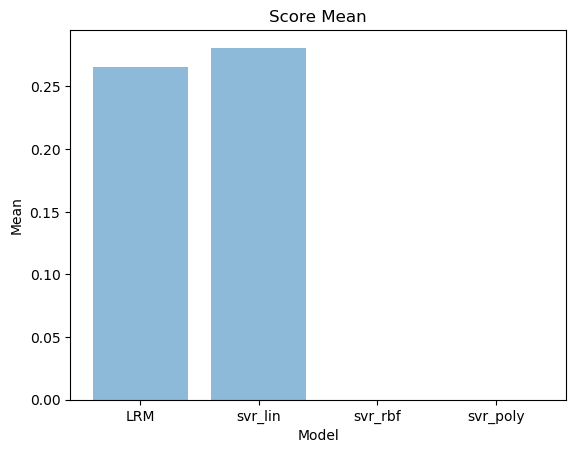

In [13]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('LRM', 'svr_lin', 'svr_rbf', 'svr_poly')
y_pos = np.arange(len(objects))
performance = [LRM_cross.mean(), np.array([0.356   , 0.320, 0.289, 0.230, 0.210]).mean(), 0, 0]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Model')
plt.title('Score Mean')

plt.show()

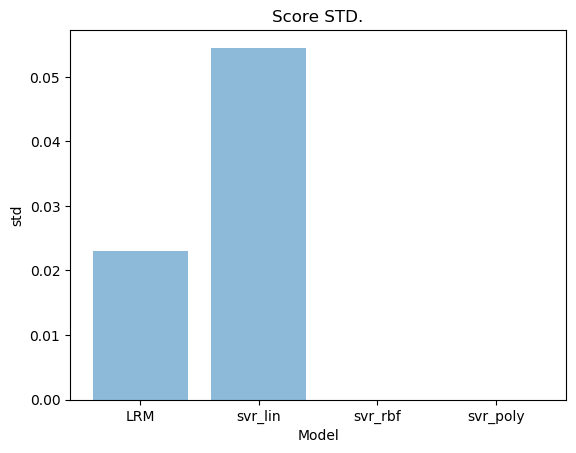

In [14]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('LRM', 'svr_lin', 'svr_rbf', 'svr_poly')
y_pos = np.arange(len(objects))
performance = [LRM_cross.std(), np.array([0.356   , 0.320, 0.289, 0.230, 0.210]).std(), 0, 0]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('std')
plt.xlabel('Model')
plt.title('Score STD.')

plt.show()

## 2.2 ทดสอบโมเดลทั้ง 4 แบบ ที่กำหนดพารามิเตอร์ไว้ในข้อ 2.1

In [33]:
# ทำการ train โมเดลทั้ง 4 แบบ ด้วยข้อมูล Train ที่แบ่งไว้
LRM.fit(np.array(X_train).reshape(-1, 1), y_train)
# svr_lin.fit(np.array(X_train).reshape(-1, 1), y_train)
# svr_rbf.fit(np.array(X_train).reshape(-1, 1), y_train)
# svr_poly.fit(np.array(X_train).reshape(-1, 1), y_train)

# ทำการ predict ข้อมูลชุด Validation และ Test
LRM_pred_valid = LRM.predict(np.array(X_valid).reshape(-1, 1))
LRM_pred_test  = LRM.predict(np.array(X_test).reshape(-1, 1))

# svr_lin_pred_valid = svr_lin.predict(np.array(X_valid).reshape(-1, 1))
# svr_lin_pred_test = svr_lin.predict(np.array(X_test).reshape(-1, 1))

# svr_rbf_pred_valid = svr_rbf.predict(np.array(X_valid).reshape(-1, 1))
# svr_rbf_pred_test = svr_rbf.predict(np.array(X_test).reshape(-1, 1))

# svr_poly_pred_valid = svr_poly.predict(np.array(X_valid).reshape(-1, 1))
# svr_poly_pred_test = svr_poly.predict(np.array(X_test).reshape(-1, 1))

# คำนวณค่าตัววัดประสิทธิภาพของการทำนายจากโมเดลทั้ง 4 แบบ โดยวัดค่า MSE และ R2
from sklearn import metrics

def perfomance_measure(model_name, model_pred_valid, model_pred_test) :
    msr_valid = metrics.mean_squared_error(y_valid, model_pred_valid)
    msr_test = metrics.mean_squared_error(y_test, model_pred_test)
    r2_valid = metrics.r2_score(y_valid, model_pred_valid)
    r2_test = metrics.r2_score(y_test, model_pred_test)
    
    print('Mean Squared Error LRM validation set:', msr_valid)
    print('Mean Squared Error LRM test set:', msr_test)
    print('R2 LRM validation set: ', r2_valid)
    print('R2 LRM test set: ', r2_test)
    
    return msr_valid, msr_test, r2_valid, r2_test

LRM_msr_valid, LRM_msr_test, LRM_r2_valid, LRM_r2_test = perfomance_measure('LRM', LRM_pred_valid, LRM_pred_test)
# LRM_msr_valid, LRM_msr_test, LRM_r2_valid, LRM_r2_test = perfomance_measure('svr_lin', svr_lin_pred_valid, svr_lin_pred_test)
# LRM_msr_valid, LRM_msr_test, LRM_r2_valid, LRM_r2_test = perfomance_measure('svr_rbf', svr_rbf_pred_valid, svr_rbf_pred_test)
# LRM_msr_valid, LRM_msr_test, LRM_r2_valid, LRM_r2_test = perfomance_measure('svr_poly', svr_poly_pred_valid, svr_poly_pred_test)

Mean Squared Error LRM validation set: 0.029977434601278753
Mean Squared Error LRM test set: 0.1186275561982066
R2 LRM validation set:  0.24768229913839257
R2 LRM test set:  -257.7397819190606


In [34]:
# แสดงรูปกราฟเปรียบเทียบผลการ Predict validation และ Predict test ข้างต้นจากโมเดลทั้ง 4 

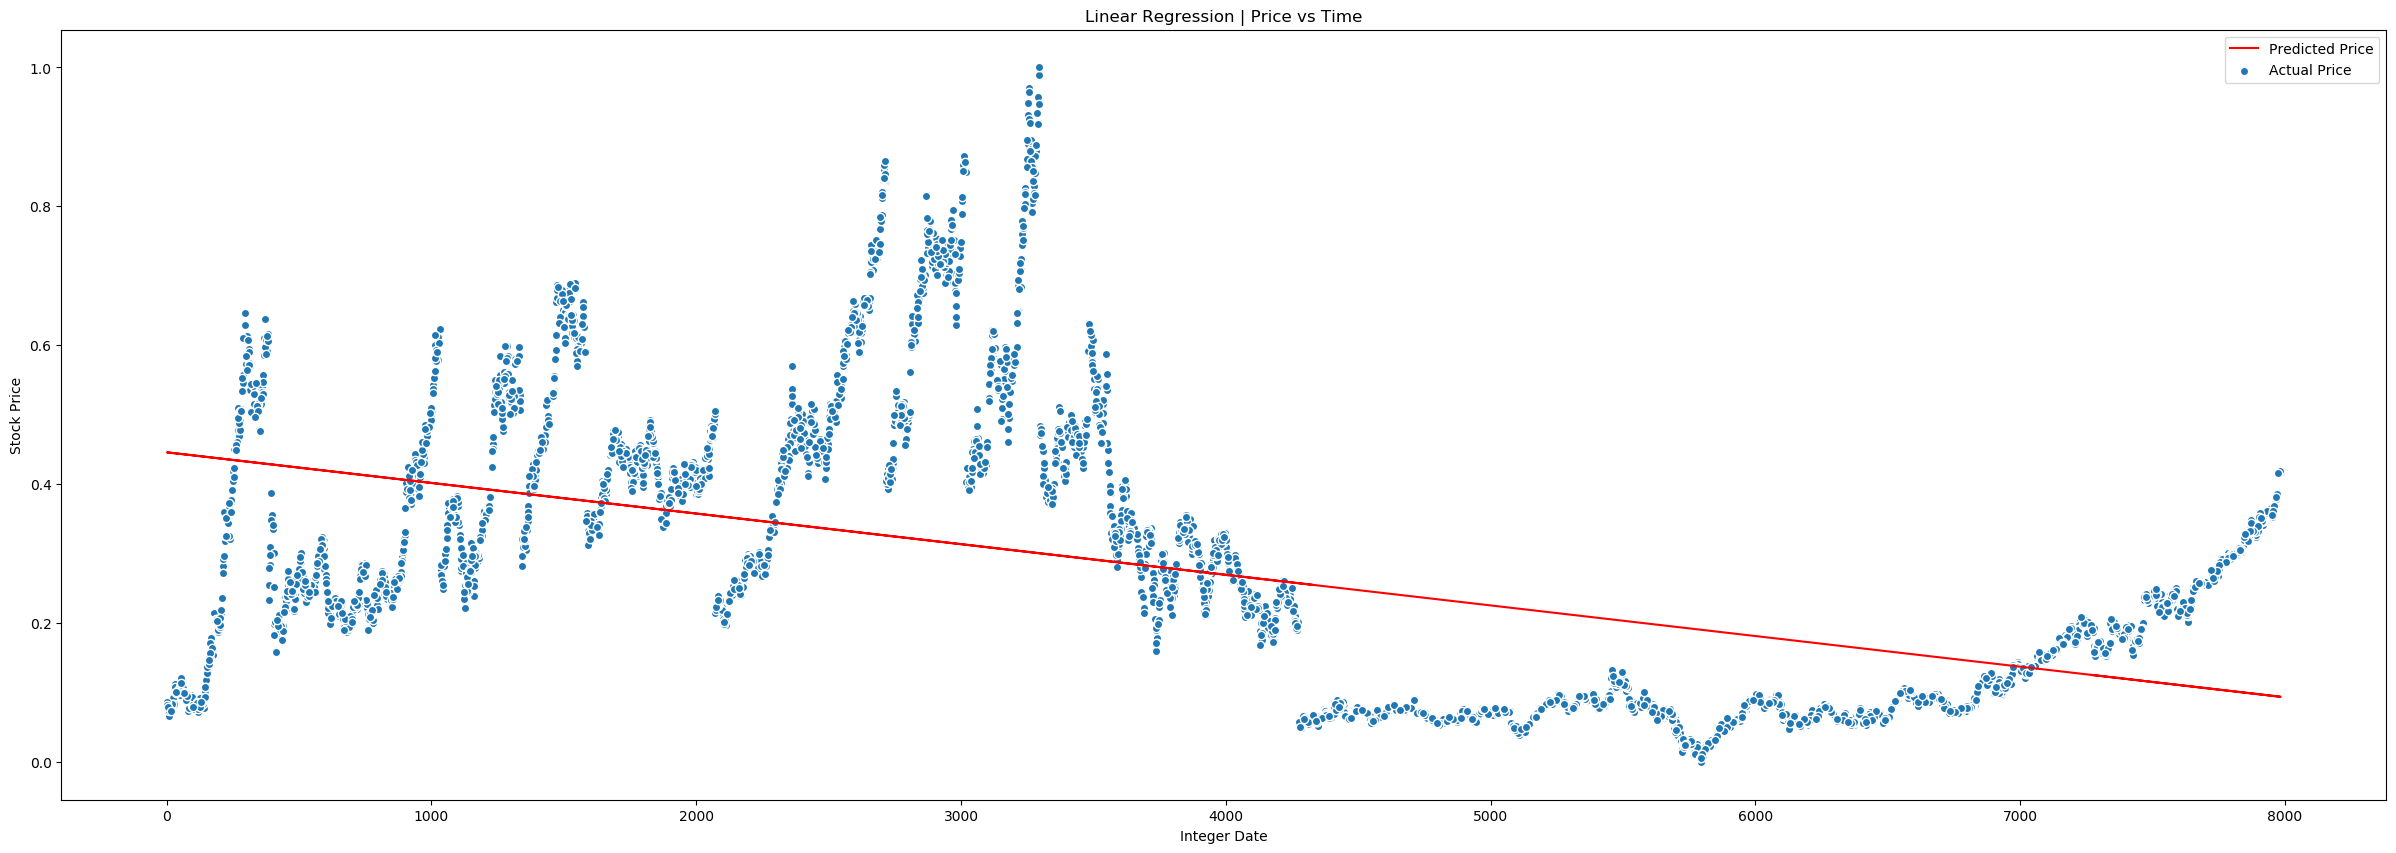

In [35]:
# Train set graph
plt.figure(1, figsize=(30,10))
plt.title('Linear Regression | Price vs Time')
plt.scatter(X_train, y_train, edgecolor='w', label='Actual Price')
plt.plot(X_train, LRM.predict(np.array(X_train).reshape(-1, 1)), color='r', label='Predicted Price')
plt.xlabel('Integer Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# ตอนที่ 3: การทดลองการค้นหาพารามิเตอร์ที่ดีที่สุดสำหรับโมเดล

## 3.1 กำหนดรายการพารามิเตอร์ทั้งหมดที่ต้องการทดสอบหาค่าที่ดีที่สุดของโมเดล SVC

## 3.2 เตรียมการค้นหาพารามิเตอร์ที่ดีที่สุดโดยใช้ฟังก์ชั่น GridSearchCV 

## 3.3 ทำการ predict ข้อมูลชุด Validation และ Test

## 3.4 คำนวณค่าตัววัดประสิทธิภาพของการทำนายที่ได้จากข้อ 3.5 โดยวัดค่า MSE และ R2

## 3.6 แสดงรูปกราฟเปรียบเทียบผลการ Predict validation และ Predict test ข้างต้นจากโมเดลทั้ง 4 แบบ โดยในรูปแบบกราฟที่แสดงเห็นความแตกต่างชัดเจน เช่น กราฟ plot, bar, scatter เป็นต้น